# 1 Introducción

El siguiente cuaderno realiza una operación entre dos vectores de "precios de productos". El algoritmo lo que hace es calcular el porcentaje de aumento o descuento de un precio.

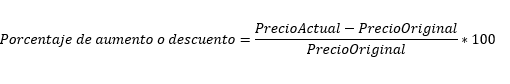

Para lograrlo, se generan dos vectores con N cantidad de precios(ingresadas por el usuario) con números aleatorios entre 50 y 100.

El objetivo es demostrar la aplicación de CUDA a las operaciones entre vectores utilizando Python y la plataforma Colab.

---

# 2 Armado del ambiente

Instala en el cuaderno el módulo CUDA de Python.



In [ ]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 22.9MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
     |████████████████████████████████| 81kB 12.2MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621228 sha256=a2d5d6ee1002200ddad2d86724385a9dab82e007a310259444d4db169c8065ab
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=edec328ffa1da848153f7d9b05905bfdfcd310c2662360b6291bfae81c086d21
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


# 3 Desarollo


Ejecuta el código en GPU




In [ ]:
# --------------------------------------------
#@title 3.1 Parámetros de ejecución { vertical-output: true }

cant_precios =   15000000#@param {type: "number"}

# --------------------------------------------

try:
  from datetime import datetime

  tiempo_total = datetime.now()

  import pycuda.driver as cuda
  import pycuda.autoinit
  from pycuda.compiler import SourceModule

  import numpy

  from datetime import datetime

  tiempo_total = datetime.now()

  import pycuda.driver as cuda
  import pycuda.autoinit
  from pycuda.compiler import SourceModule

  import numpy

  # --------------------------------------------
  # Definición de función que transforma el tiempo en  milisegundos 
  tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

  # CPU - Defino la memoria de los vectores en cpu.

  #Pongo vectores de precios entre 50 y 100 para facilitar el testing
  x_cpu = numpy.random.randint(50,100, cant_precios)
  x_cpu = x_cpu.astype( numpy.float32() )

  y_cpu = numpy.random.randint(50,100, cant_precios)
  y_cpu = y_cpu.astype( numpy.float32() )

  #Inicializo vector de resultados con 0 y lo copio al CPU
  precios_cpu = numpy.zeros(cant_precios)
  precios_cpu = precios_cpu.astype( numpy.float32() )

  
  # CPU - reservo la memoria GPU.
  x_gpu = cuda.mem_alloc( x_cpu.nbytes )
  y_gpu = cuda.mem_alloc( y_cpu.nbytes )
  precios_gpu = cuda.mem_alloc( precios_cpu.nbytes )

  # GPU - Copio la memoria al GPU.
  cuda.memcpy_htod( x_gpu, x_cpu )
  cuda.memcpy_htod( y_gpu, y_cpu )
  cuda.memcpy_htod( precios_gpu, precios_cpu )

  # CPU - Defino la función kernel que ejecutará en GPU.
  module = SourceModule("""
  __global__ void kernel_diferencia_precios( int n, float *X, float *Y, float *P )
  {
    int idx = threadIdx.x + blockIdx.x*blockDim.x;
    if( idx < n )
    {
      P[idx]  = ((Y[idx] - X[idx]) / X[idx]) * 100;
    }
  }
  """) 
  # CPU - Genero la función kernel.
  kernel = module.get_function("kernel_diferencia_precios")

  tiempo_gpu = datetime.now()

  # GPU - Ejecuta el kernel.
  dim_hilo = 256
  dim_bloque = numpy.int( (cant_precios + dim_hilo - 1) / dim_hilo )
  print( "Thread x: ", dim_hilo, ", Bloque x:", dim_bloque )

  #TODO: Ojo, con los tipos de las variables en el kernel.
  kernel( numpy.int32(cant_precios), x_gpu, y_gpu, precios_gpu, block=( dim_hilo, 1, 1 ),grid=(dim_bloque, 1,1) )

  tiempo_gpu = datetime.now() - tiempo_gpu

  # GPU - Copio el resultado desde la memoria GPU.
  cuda.memcpy_dtoh( precios_cpu, precios_gpu )

  
  # CPU - Informo el resutlado.
  print( "------------------------------------")
  print( "X: ", "\n" )
  print( x_cpu , "\n")
  print( "------------------------------------")
  print( "Y: ", "\n" )
  print( y_cpu, "\n" )
  print( "------------------------------------")
  print( "Porcentaje de precios resultado: ", "\n")
  print( precios_cpu , "\n")

  tiempo_total = datetime.now() - tiempo_total

  print( "Cantidad de precios: ", cant_precios, "\n" )
  print( "Thread x: ", dim_hilo, ", Bloque x:", dim_bloque )
  print("Tiempo Total: ", tiempo_en_ms( tiempo_total ), "[ms]" )
  print("Tiempo GPU: ", tiempo_en_ms( tiempo_gpu   ), "[ms]" )


except Exception as exception:
  print("Ups, hubo una excepción: ")
  print(exception);



Thread x:  256 , Bloque x: 58594
------------------------------------
X:  

[55. 77. 98. ... 90. 93. 89.] 

------------------------------------
Y:  

[61. 60. 61. ... 60. 77. 54.] 

------------------------------------
Porcentaje de precios resultado:  

[ 10.909091 -22.077923 -37.7551   ... -33.333336 -17.204302 -39.325844] 

Cantidad de precios:  15000000 

Thread x:  256 , Bloque x: 58594
Tiempo Total:  435.212 [ms]
Tiempo GPU:  0.608 [ms]


---
# 4 Tabla de pasos de ejecución del programa


 Procesador | Función | Detalle
------------|---------|----------
CPU      |  @param                | Lectura del tamaño de vectores de precios desde Colab.
CPU      |  import                | Importa los módulos para funcionar.
CPU      |  datetime.now()        | Toma el tiempo actual.
CPU      |  numpy.random.randint(50, 100, cantidad_precios ) | Inicializa los vectoes X e Y con números entre 50 y 100
CPU      |  x_cpu.astype( numpy.float32() ) | Determina el tipo de dato del array, para el caso float de 32 bits
CPU      |  numpy.zeros( cantidad_precios ) | Inicializa el vector de resultado (precios) en 0
**GPU**  |  cuda.mem_alloc()      | Reserva la memoria en GPU.
**GPU**  |  cuda.memcpy_htod()    | Copia las memorias desde el CPU al GPU.
CPU      |  SourceModule()        | Define el código del kernel 
CPU      |  module.get_function() | Genera la función del kernel GPU
CPU      |  dim_tx/dim_bx         | Calcula las dimensiones.
**GPU**  |  kernel()              | Ejecuta el kernel en GPU
CPU      |  cuda.memcpy_dtoh( )   | Copia el resultado desde GPU memoria A a CPU memoria R.
CPU      |  print()               | Informo los resultados.


---
# 5 Conclusiones

En este ejercicio, utilizando CUDA se demostró la eficiencia y la reducción de tiempo de cálculo y procesamiento al realizar el mismo ejercicio que se hizo antes (CPU - SECUENCIAL) pero ahora en un procesador de gráficos GPU y utilizando threads que acceden cada uno a una posición del vector, con lo cual se gana mucha mas velocidad ya no es necesario un ciclo for.

Si el N de precios (tamaño del vector) es chico, los cambios no son significativos, pero se hizo una prueba con 15 millones de números y en el CPU tardó 17 segundos y en el GPU utilzando CUDA tardó 0.6ms. 


**Lecciones aprendidas**: No olvidar utilizar el GPU para procesamientos matemáticos. Cuda es de gran utilidad debido a que permite acceder en simultaneo a varias posiciones del array por cada thread y eso permite que el cálculo sea mucho mas veloz.
**Sugerencias del algoritmo**: sería útil darle la posibilidad al usuario  de que cargue sus propios valores deprecios (por ejemplo desde un CSV) y probarlo con un archivo real y grande para darle una útilidad concreta.

---
# 6 Bibliografia

[1] MARKDOWN SYNTAX Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[2] Introducción a Python: [Página Colab](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb) 

[3] Documentacion randInt [Numpy randInt](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html) 

[4] Documentación PyCUDA: [WEB](https://documen.tician.de/pycuda/index.html)

[5] Repositorio de PyCUDA: [WEB](https://pypi.python.org/pypi/pycuda)

[6] Numpy ceros: [numpyZeros](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html?highlight=zeros#numpy.zeros)

[7] Variación porcentual (aplicado a precios): [WEB](https://www.ck12.org/book/ck-12-conceptos-de-%c3%a1lgebra-nivel-b%c3%a1sico-en-espa%c3%b1ol/section/3.11/)